# Image Segmentation for Background Biased Images Classification

## Importing required libraries

In [30]:
!pip install captum
!pip install natsort
!pip install torchview

In [31]:
import os, sys, itertools, glob, torch, torchvision, cv2, natsort
import numpy as np 
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
torch.manual_seed(46)
from torch import nn
from torchvision.models import resnet101, ResNet101_Weights
import torchvision
from torchview import draw_graph
import torch.nn.functional as F
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel, GuidedGradCam

## Exploratory Data Analysis

The objective of this work was to classify eight different types of hand-held objects:

0. double plug
1. mobile phone
2. scissor
3. bulb
4. canned drink
5. sunglasses
6. ball
7. cup

The train set was divided into subfolders where each folder represent the class, while the test set was provided without labels. In addition, a ".csv" file containing the bounding boxes, indicating the location of each object, was provided for both train and test set. \
The approach used in this work didn't take into consideration the bounding boxes, trying to locate and classify the objects throw the following image preprocessing and augmentation techniques.

In [ ]:
print('Folders inside the train directory: ', os.listdir("/kaggle/input/aiunict-2023/train"))

Folders inside the train directory:  ['07', '05', '06', '02', '04', '00', '03', '01']


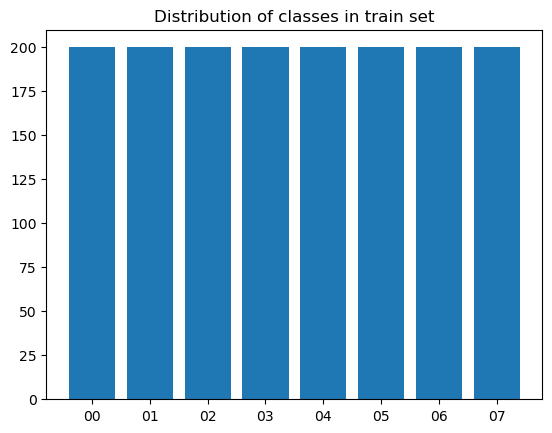

Total number of images in test set:  800


In [ ]:
classes = ['00', '01', '02', '03', '04', '05', '06', '07']
sum_images = []
for i in range(8):
    img_base_path = "/kaggle/input/aiunict-2023/train/" + str(0) + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes in train set')
plt.show()

test_path = "/kaggle/input/aiunict-2023/test"
test_images = os.listdir(test_path)
print("Total number of images in test set: ", len(test_images))

The  dataset is quite small, composed by 200 images for each of the eight classes for the train set and 800 unlabeled images for the test set. 

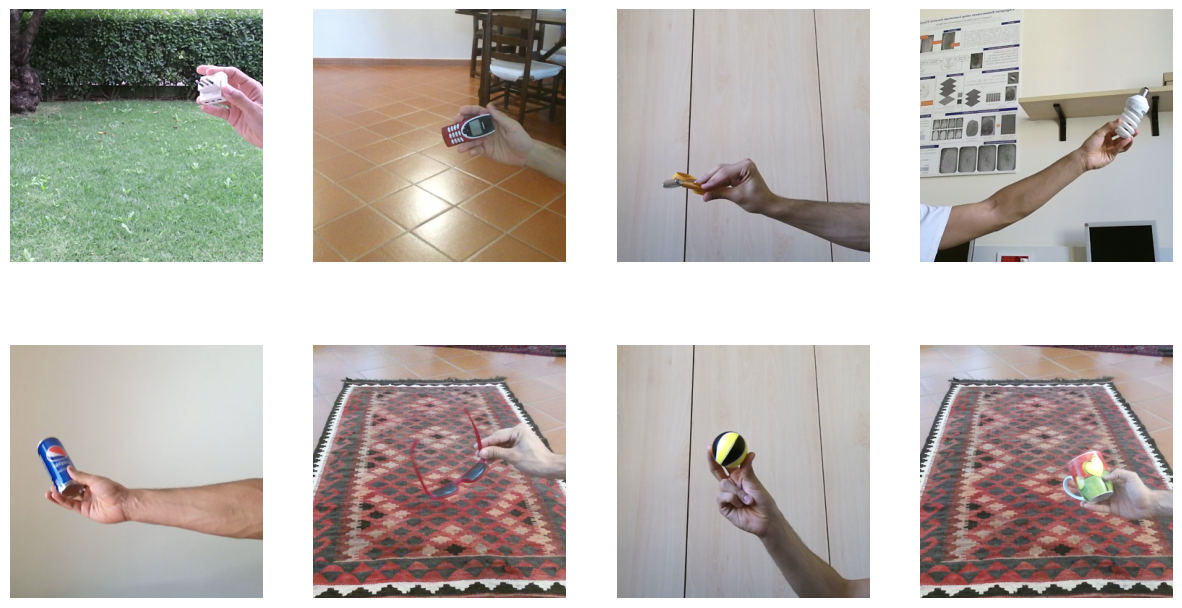

In [74]:
images = []
paths = []

fig,ax = plt.subplots(2,4,figsize = (15,8))
ax = ax.ravel()

for i in range(8):
    img_base_path = "/kaggle/input/aiunict-2023/train/" + str(0) + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[i]
    ax[i].axis('off')
    ax[i].imshow(image,cmap = 'gray')

plt.show()

The main problem that can be detected by inspecting the images is that, while classes from 1 to 7 contains a quite mixed background (carpet, wall), class 0 contains the same background for all the images which is different from the other classes. This behavior can lead the model to identify the double plug from the tree on the left part of the image or from the grass in the background. \
For this reason, in order to remove bias, an image segmentation on class 0 is required. 

## Image Preprocessing

Just for an example, the plot below represents one of the 200 images from class 0 of train set:

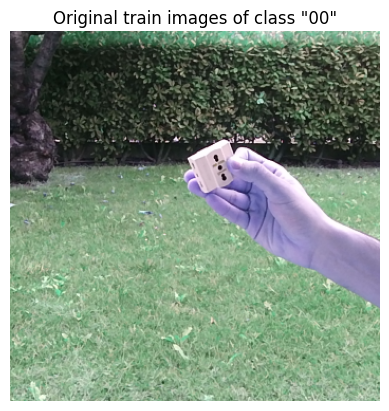

In [75]:
img = cv2.imread('/kaggle/input/aiunict-2023/train/00/00_000.png')
plt.axis('off')
plt.imshow(img)
plt.title('Original train images of class "00"')
plt.show()

As mentioned above, the background for class 0 is always the same, this lead the model to learn from two different distribution and to attribute to class 0 other details which doesn't belong to the object. \
In particular, we can see that there are two different shades of green, some darker part and a lighter part belonging to the hand which held the object. \
The first objective would be to remove the green and the tree, which represent a misleading detail.

### 1) RGB to HSV Scale

While the previous image was visualized in RGB scale, where each channel represents value from 0 to 255 for each red, blue and green value, the image below is visualized in HSV scale. Here, there are three channels but the meaning is different: 
* the first channel (Hue) contains the colour informations, 
* the second channel (Saturation) contains information about the intensity of each pixel,
* the third channel (Value) contains informations about how light or dark is each pixel. 

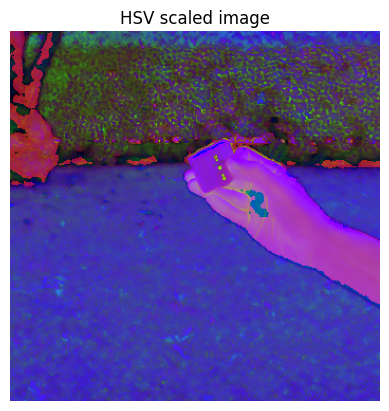

In [77]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.axis('off')
plt.imshow(hsv)
plt.title('HSV scaled image')
plt.show()

### 4) Foreground selection

The HSV scaled image allows me to select the part of the image which represent the foreground, excluding the background, by taking into referments the values of green in HSV in the image below:

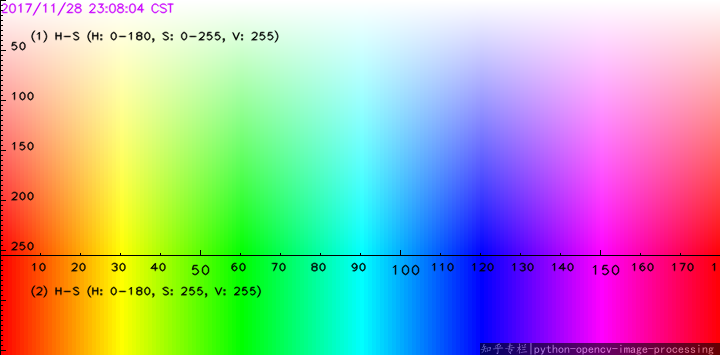

As we can see, the green corresponds to range [36, 89] in the x-axis representing the hue, and to range [25, 255] in the y-axis representing the saturation, and same range for the values. \
Once the background has been selected we impose a mask to show all but that selected range. The image below represent the mask, which is composed by binary values (0 for the black pixels and 1 for the white pixels).

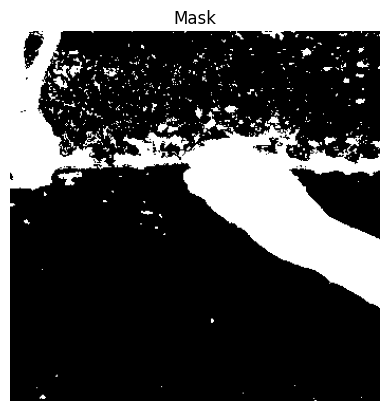

In [78]:
mask = cv2.inRange(hsv, (36, 25, 25), (89, 255,255))
mask = cv2.bitwise_not(mask)
plt.axis('off')
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

I finally selected those pixels from the original RGB image which was not covered by the mask. The final results will be a selected foreground without the grass on the background.

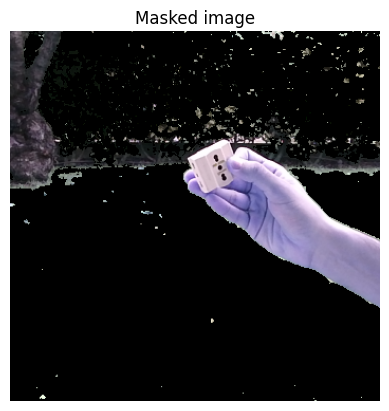

In [79]:
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]
plt.imshow(green)
plt.axis('off')
plt.title('Masked image')
plt.show()

In [ ]:
def background_remove(img):
    img = asarray(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (36, 25, 25), (89, 255,255))
    mask = cv2.bitwise_not(mask)
    imask = mask>0
    green = np.zeros_like(img, np.uint8)
    green[imask] = img[imask]
    green = Image.fromarray(green)
    return green

### Image Augmentation

The second important step is the selection of a proper image augmentation techniques. Considering the presence of the tree which can misleading the model, I decided to center crop each image by deleting the 50 pixels of pad for each side: this allows to quite simulate the bounding boxes by deleting useless details from image and to have more chance to detect the object. Then, the image was resized to 250 pixels to allow the model to go throw a less amount of pixels. \
Then, each image will be flipped horizontally, vertically and rotated of 380° to allow to get more perspective of the object. \
Finally, the AugMix augmentation was applied: this is a technique to enhance robustness and uncertainty measures which fit perfectly the problem of mismatch between train ans test set, not identically distributed in this case. In particular, the algorithm apply a series of layered augmentations such as: posterize rotate and translate as single augmentations, then, sheare the translated images and equalize the posterized images. The resulting image will be generated by mixing the three outputted images, like the image below, coming from the original paper, shows.

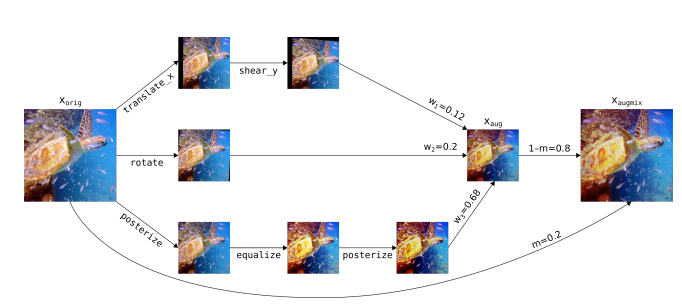

In addition, in order to simulate the test set, 30% of images was extracted from the train set, the background was not removed and the images was not augmented. Instead, the pad was deleted by applying a center crop of 300 pixels and resizing the image at 250 pixels to allow the model to receive a similar image than what learned. 

In [ ]:
data = datasets.ImageFolder('/kaggle/input/aiunict-2023/train')
train, validation = random_split(data, [0.7, 0.3])
print(len(train))
print(len(validation))

In [ ]:
transform = transforms.Compose([transforms.CenterCrop(300),
                                transforms.Resize(250),
                                transforms.RandomHorizontalFlip(1),
                                transforms.RandomVerticalFlip(1),
                                transforms.RandomRotation(180),
                                transforms.AugMix(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5227, 0.4927, 0.4786], std=[0.3068, 0.3044, 0.3066])])

notransform = transforms.Compose([transforms.CenterCrop(300),
                                  transforms.Resize(250),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5227, 0.4927, 0.4786], std=[0.3068, 0.3044, 0.3066])])

Then, on all the training images, the Augmix technique is applied as an image augmentation technique: this is a technique to enhance robustness and uncertainty measures which fit perfectly the problem of mismatch between train ans test set, not identically distributed in this case. \
In particular, the algorithm apply a series of layered augmentations such as: posterize rotate and translate as single augmentations, then, sheare the translated images and equalize the posterized images. The resulting image will be generated by mixing the three outputted images. 

In [ ]:
class loadTrainData(Dataset):
    def __init__(self, dataset, background_remove = None, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.background_remove = background_remove
        
    def __getitem__(self, index):
        if self.background_remove:
            if self.transform:
                if self.dataset[index][1] == 0:
                    x = self.transform(self.background_remove(self.dataset[index][0]))
                else:
                    x = self.transform(self.dataset[index][0])
          
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)
    
    
    
class loadValData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
          
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
traindataset = loadTrainData(train, background_remove, transform)
valdataset = loadValData(validation, notransform)

In [ ]:
print(traindataset[0][0].shape)

torch.Size([3, 250, 250])


As we can see, the shape of each image is 250x250 as spatial dimentions, which has been left untopuched, 3 RGB channels as depth. \
The images below shows an example of two random augmented images:

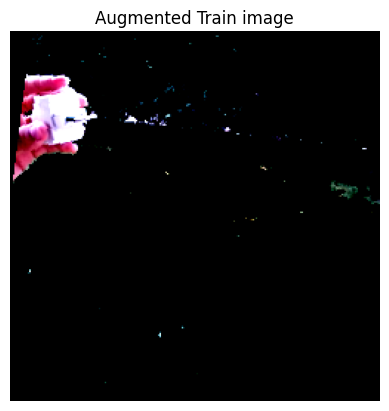

In [80]:
plt.imshow(traindataset[3][0].permute(1, 2, 0))
plt.axis('off')
plt.title('Augmented Train image')
plt.show()

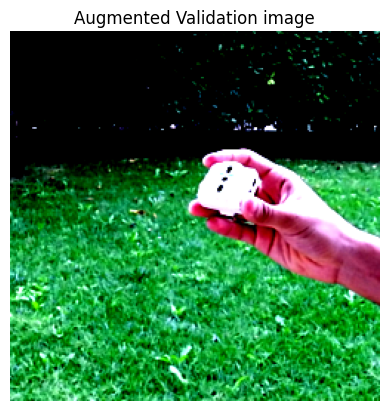

In [81]:
plt.imshow(valdataset[5][0].permute(1, 2, 0))
plt.axis('off')
plt.title('Augmented Validation image')
plt.show()

In [ ]:
train_set = DataLoader(traindataset, batch_size=32, shuffle=True, drop_last=True)
val_set = DataLoader(valdataset, batch_size=32, shuffle=True, drop_last= True)

The images was then divided into batches of 32 images, which have been shuffled before training and the last batch has been removed to avoid being odd. Thus, the batch will be added as an additional dimention to the tensor.

In [ ]:
examples = next(iter(train_set))
for label, img  in enumerate(examples):
    print(img.shape)

torch.Size([32, 3, 250, 250])

torch.Size([32])


As we can see, we added an additional dimention which represent the number of image for each batch. 

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

get_mean_and_std(train_set)

(tensor([0.5211, 0.4891, 0.4751]), tensor([0.3075, 0.3044, 0.3066]))

Finally, in order to allow the model to learn from images which behaves in the same way, the mean and standard deviation of each channel was computed to normalize the image before feeding the network. Then, the values above was added in the transformation flow. 

## Training

In [ ]:
dev = torch.device('cuda')

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        # Initialize history
        history_loss = {"train": [], "val": []}
        history_accuracy = {"train": [], "val": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0}
            sum_accuracy = {"train": 0, "val": 0}
            # Process each split
            for split in ["train", "val"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val"]}
            # Update history
            for split in ["train", "val"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"Train Loss={epoch_loss['train']:.4f},",
                  f"Train Accuracy={epoch_accuracy['train']:.4f},",
                  f"Validation Loss={epoch_loss['val']:.4f},",
                  f"Validation Accuracy={epoch_accuracy['val']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

### Extreme Inception CNN

The final step to allows the model to detect the location and correctly classify the images with the application of a proper network architecture, able to do so. \
The convolution is based on the application of various weighted kernels which go throw the channels, usually while reducing the spatial dimentions (height and weight), in order to capture particular characteristics of an image, increasing depth and decreasing spatial dimentions.
For this purpose, I decided to build and train my own network architecture without any pretrained weights. Previous pretrained models applied to the same preprocessed images leads me to almost 80% of accuracy on both validation and test set, however, the usage of a model trained from scratch allows to capture the specific features of this types of images, quite different from those of Imagenet, gaining a lower but much effective accuracy on test set. \
The model used for this work is the[ Xception](https://hitesh.one/hedwig-explains/paper/deeplearning/2020/10/28/xception-explaination.html) architecture, builded by F. Chollet, a researcher of Google. \
The architecture is based on three main blocks: 
* the entry flow which receives the input and apply a series of separable convolution followed by a pointwise convolutions with skip connection while reducing the spatial dimentions,
* the middle flow that is repeated eight times, where each feature map follow the depthwise separable convolution without any spatial dimentions reduction,
* the exit flow, where again spatial dimention reduction is computed and the classification is produced. \

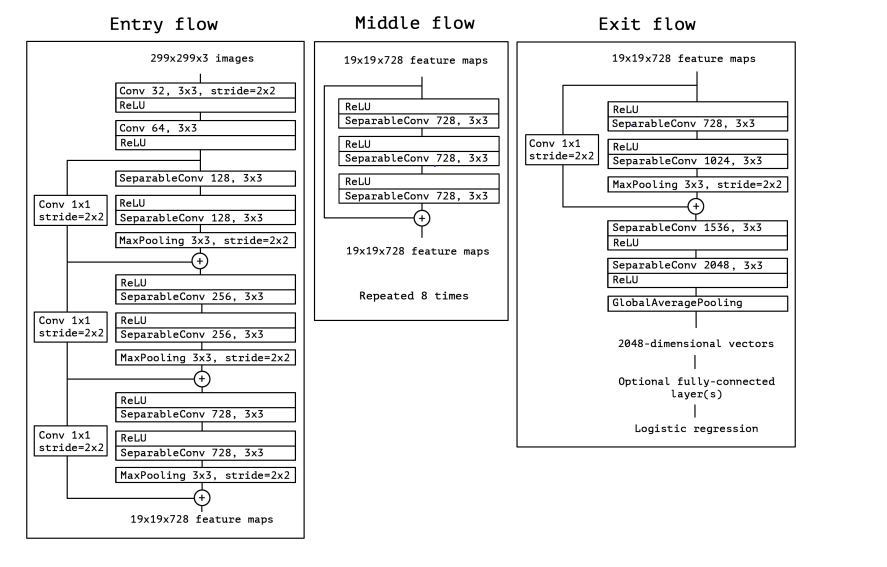

Each flow contains a depthwise separable convolution block: the point is to apply various kernel on the input channel, one for each channel indipendently; those kernels will be then concatenated and will pass throw the pointwise convolution (1x1 kernel) to reduce the complexity of this output. In particular, that pointwise convolution apply a skip connection too, in order to avoid vanishing gradient by carrying out informations about the previous layer. \
The picture below represents the whole structure of my model. 

In [2]:
class DepthWiseSeparable(nn.Module):
    def __init__(self, channels, middle_flow= False):
        super(DepthWiseSeparable, self).__init__()
        
        # block for entry flow
        if middle_flow== False: 
        
            self.block= nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
                nn.BatchNorm2d(channels[1]),
                nn.MaxPool2d(3,stride=2, padding=1),
            )
        
        # block for middle flow
        if middle_flow==True:
            self.block= nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
                nn.BatchNorm2d(channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),                
            )

        # block for exit flow
        
        if middle_flow=='Exit':
            self.block= nn.Sequential(
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[2],1),
                nn.BatchNorm2d(channels[2]),
                nn.ReLU(),
            )


    
    def forward(self,x):
        x= self.block(x)
        return x

In [3]:
class Xception(nn.Module):
    def __init__(self, DepthWiseSeparable):
        super(Xception, self).__init__()

        self.conv1_3x3 = nn.Conv2d(3,32,3,stride=2,padding=1)
        self.bn1 =nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.conv2_3x3= nn.Conv2d(32,64,3,stride=1,padding=1)
        self.bn2 =nn.BatchNorm2d(64)
        self.relu= nn.ReLU()
        #Entry flow
        self.block_3x3= DepthWiseSeparable(channels=[64,128])
        self.downsample_1= nn.Conv2d(64,128,1,stride=2)

        self.block_3x3_256= DepthWiseSeparable(channels=[128,256])
        self.downsample_2= nn.Conv2d(128,256,1,stride=2)

        self.block_3x3_728= DepthWiseSeparable(channels=[256,728])
        self.downsample_3= nn.Conv2d(256,728,1,stride=2)
        #Middle Flow
        self.block_3x3_middle= DepthWiseSeparable(channels=[728,728], middle_flow=True)
        #Exit flow
        self.block_3x3_exit = DepthWiseSeparable(channels=[728,1024])
        self.downsample_4= nn.Conv2d(728,1024,1,stride=2)

        self.block_3x3_exit_2 = DepthWiseSeparable(channels=[1024,1536,2048], middle_flow='Exit')
        
        self.avgpool= nn.AdaptiveAvgPool2d((1,1))

        self.fc= nn.Linear(2048,8)

    def forward(self,x):
        x= self.relu(self.bn1(self.conv1_3x3(x)))
        x_identity = self.relu(self.bn2(self.conv2_3x3(x)))
        x_res_1= self.block_3x3(x_identity)
        x_identity= self.downsample_1(x_identity)        
        x_identity= x_identity+x_res_1
        x_res_2= self.block_3x3_256(x_identity)
        x_identity= self.downsample_2(x_identity)
        x_identity= x_identity+x_res_2
        x_res_3= self.block_3x3_728(x_identity)
        x_identity= self.downsample_3(x_identity)
        x_identity= x_identity+x_res_3

        for i in range(9):
            x_res_4= self.block_3x3_middle(x_identity)
            x_identity= x_identity+x_res_4

        
        x_res_5= self.block_3x3_exit(x_identity)
        x_identity= self.downsample_4(x_identity)

        x_identity= x_identity+x_res_5

        x_res_6= self.block_3x3_exit_2(x_identity)

        x= self.avgpool(x_res_6)

        x= x.view(x.shape[0],-1)

        x= self.fc(x)
        return x

In [4]:
model = Xception(DepthWiseSeparable)

In [ ]:
#model_graph = draw_graph(model, input_size=(1,3,250,250), roll=True, expand_nested=True, directory='/kaggle/working/')
#model_graph.visual_graph

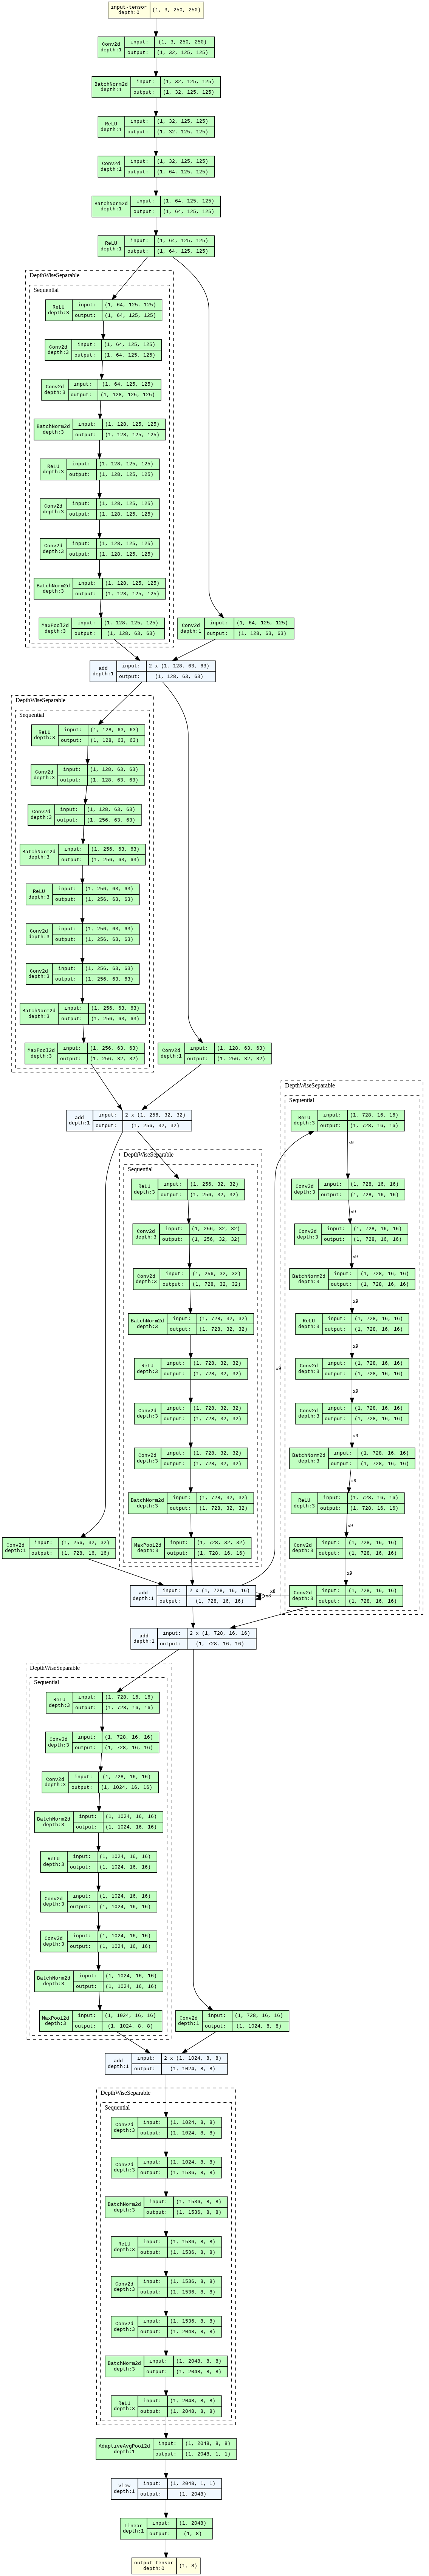

The crossentropy loss allows to compute the loss for a multiclassification task, the Stochastic Gradient Descent with a learning rate of 0.001 has been choosen as it appears to learn slowly but better than the other optimizers, with the addition of L2 regularization to enlower the difference between the train and the validation loss.

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.05)

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_set,
           "val": val_set}

Epoch 1: Train Loss=1.8318, Train Accuracy=0.2625, Validation Loss=2.1440, Validation Accuracy=0.1422,
Epoch 2: Train Loss=1.5850, Train Accuracy=0.3354, Validation Loss=1.8791, Validation Accuracy=0.2344,
Epoch 3: Train Loss=1.5044, Train Accuracy=0.3698, Validation Loss=1.7799, Validation Accuracy=0.2672,
Epoch 4: Train Loss=1.4987, Train Accuracy=0.3729, Validation Loss=2.0085, Validation Accuracy=0.2453,
Epoch 5: Train Loss=1.4437, Train Accuracy=0.3781, Validation Loss=1.8962, Validation Accuracy=0.2594,
Epoch 6: Train Loss=1.4310, Train Accuracy=0.3865, Validation Loss=1.9623, Validation Accuracy=0.3063,
Epoch 7: Train Loss=1.4266, Train Accuracy=0.3917, Validation Loss=1.9857, Validation Accuracy=0.2984,
Epoch 8: Train Loss=1.4085, Train Accuracy=0.4042, Validation Loss=1.9408, Validation Accuracy=0.3047,
Epoch 9: Train Loss=1.3571, Train Accuracy=0.4625, Validation Loss=1.9014, Validation Accuracy=0.3406,
Epoch 10: Train Loss=1.2386, Train Accuracy=0.5427, Validation Loss=1.761

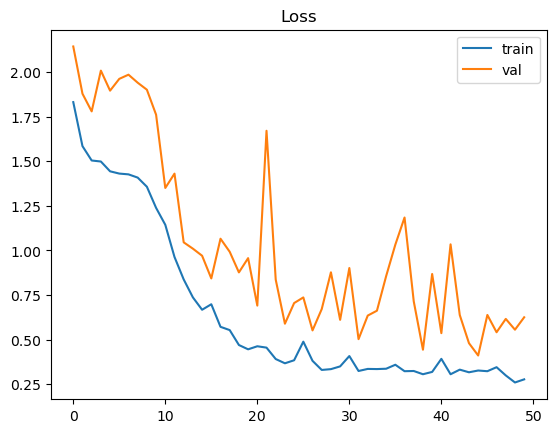

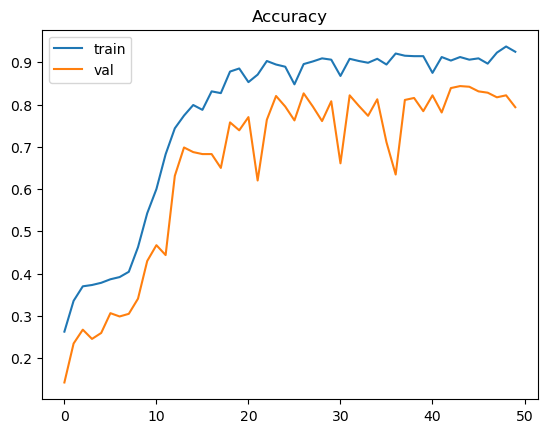

In [ ]:
# Train model
train(model, loaders, optimizer, loss, epochs=150, dev = dev)

As we can see from the plots above, training has been stopped at epoch 50 to avoid overfitting and both loss and accuracy functions decrease and increase together, even if the functions related to the validation accuracy is not so clean: this is probably due to the difference between the train images and the validation images and the low number of the images which build the dataset.

#### Comparing pretrained

In [83]:
weights = ResNet101_Weights.DEFAULT
model1 = resnet101(weights=weights)
model1

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:03<00:00, 52.9MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch 1: Train Loss=2.0100, Train Accuracy=0.3195, Validation Loss=1.9580, Validation Accuracy=0.4437,
Epoch 2: Train Loss=1.8723, Train Accuracy=0.5461, Validation Loss=1.8746, Validation Accuracy=0.5625,
Epoch 3: Train Loss=1.7532, Train Accuracy=0.6609, Validation Loss=1.7919, Validation Accuracy=0.7000,
Epoch 4: Train Loss=1.6495, Train Accuracy=0.7586, Validation Loss=1.7038, Validation Accuracy=0.7781,
Epoch 5: Train Loss=1.5634, Train Accuracy=0.7977, Validation Loss=1.6226, Validation Accuracy=0.7812,
Epoch 6: Train Loss=1.4843, Train Accuracy=0.8344, Validation Loss=1.5710, Validation Accuracy=0.8250,
Epoch 7: Train Loss=1.4145, Train Accuracy=0.8547, Validation Loss=1.4820, Validation Accuracy=0.8438,
Epoch 8: Train Loss=1.3401, Train Accuracy=0.8719, Validation Loss=1.4366, Validation Accuracy=0.8625,
Epoch 9: Train Loss=1.2900, Train Accuracy=0.8781, Validation Loss=1.3796, Validation Accuracy=0.8656,
Epoch 10: Train Loss=1.2379, Train Accuracy=0.8883, Validation Loss=1.333

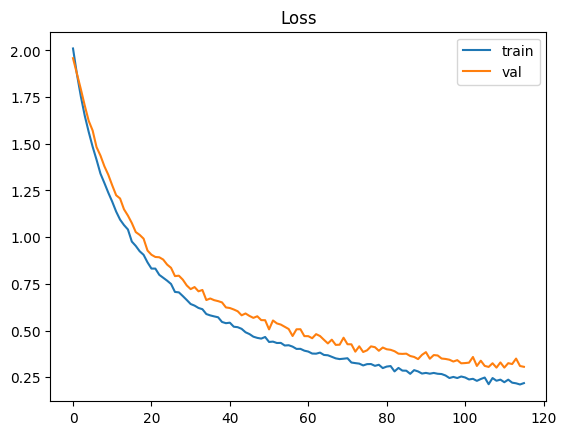

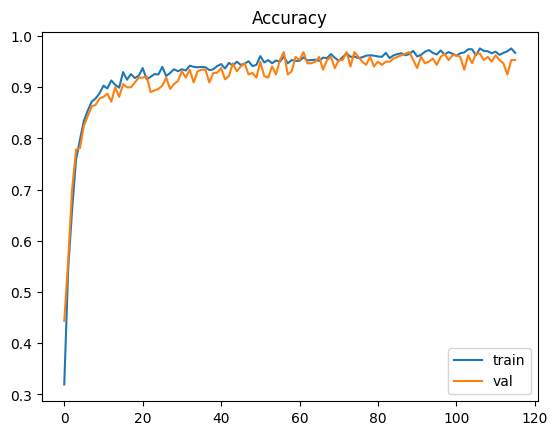

In [85]:
for param in model1.parameters():
    param.requires_grad = False
model1.fc = nn.Linear(2048, 8)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)
train(model1, loaders, optimizer, loss, epochs=150, dev = dev)

In [94]:
torch.save(model1.state_dict(), '/kaggle/working/resnet101.pth')

#### Evaluation

In [ ]:
#save trained model
torch.save(model.state_dict(), 'xception.pth')

In [34]:
#load trained model
model = Xception(DepthWiseSeparable)
state_dict = torch.load('/kaggle/input/model/xception.pth')
model.load_state_dict(state_dict)
model.to(dev)

Xception(
  (conv1_3x3): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2_3x3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block_3x3): DepthWiseSeparable(
    (block): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (6): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): MaxPool2d(kernel_size=3, stride=2, padd

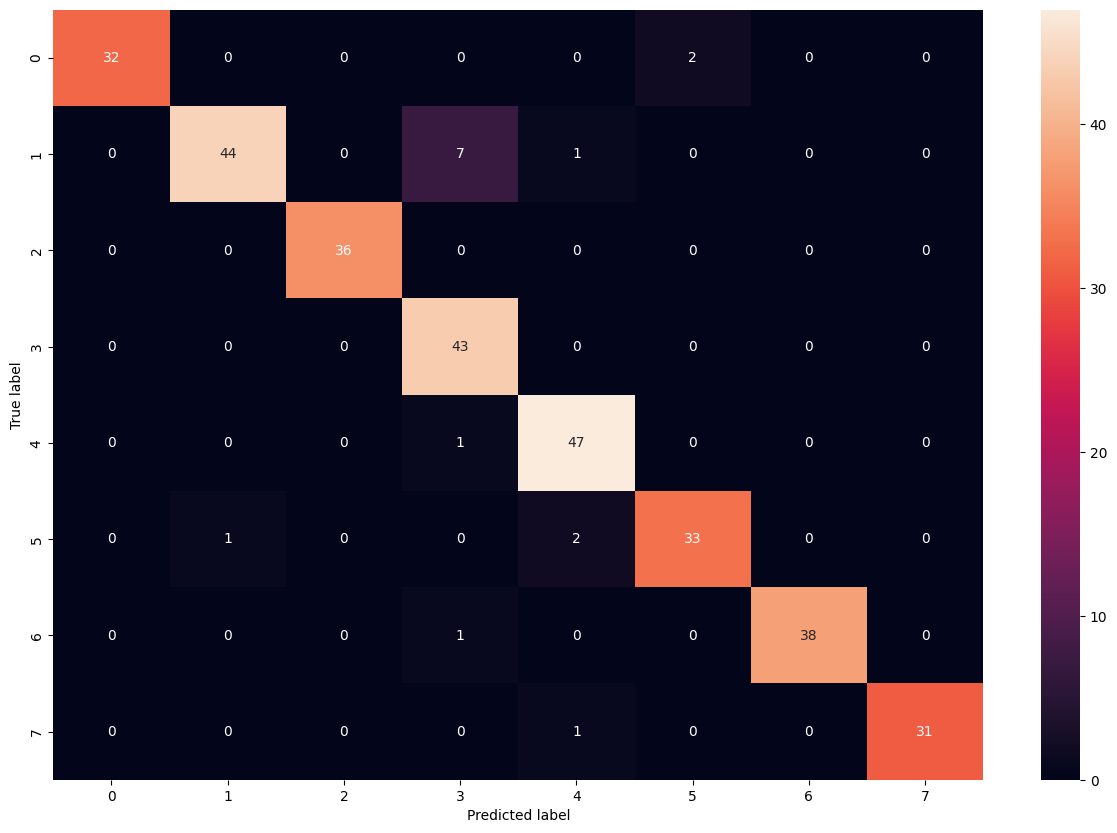

In [36]:
model.eval()
nb_classes = 8
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_set):
        inputs = inputs.to(dev)
        classes = classes.to(dev)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))


df_cm = pd.DataFrame(confusion_matrix).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The image above represents the comparison between predicted and ground truth on the validation set, which is composed by images which quite most represent the test set, in order to understand if the model was able to detect the class "0" in a more general way. \
As it's possible to see, the model behaves in an acceptable way, with much more errors on class "0" and class "1". In the section below i tryied to understand the general behavior of the model and the highlighted part of the images which lead to the classification. 

## Model Inspecting

Just for an example, I peaked a random image from the test set:

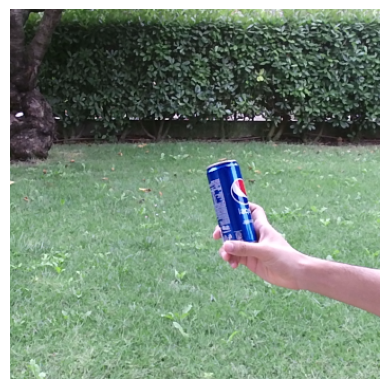

In [42]:
test_img = Image.open('/kaggle/input/aiunict-2023/test/026.jpg')
test_img_data = np.asarray(test_img)
plt.axis('off')
plt.imshow(test_img_data)
plt.show()

Before feeding the model with the image, it has been center cropped to 300 and resized to 250 to fit the required dimention of the model, and normalized according to the mean and standard deviation of each channel of the entire dataset.

In [46]:
transform = transforms.Compose([
    transforms.CenterCrop(300),
    transforms.Resize(250),
    transforms.ToTensor()])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.5227, 0.4925, 0.4786],
     std=[0.3068, 0.3044, 0.3066])

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0).to(dev)
transformed_img = transformed_img.to(dev)

In [47]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
print(pred_label_idx)

tensor(4, device='cuda:0')


The prediction is class "4", which is the corrected class for the previous test image. 

## Guided GradCam

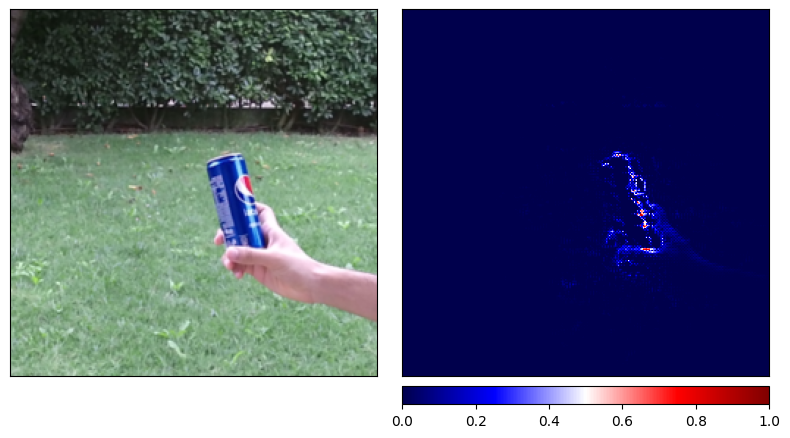

In [53]:
gg = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr = gg.attribute(input_img, pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

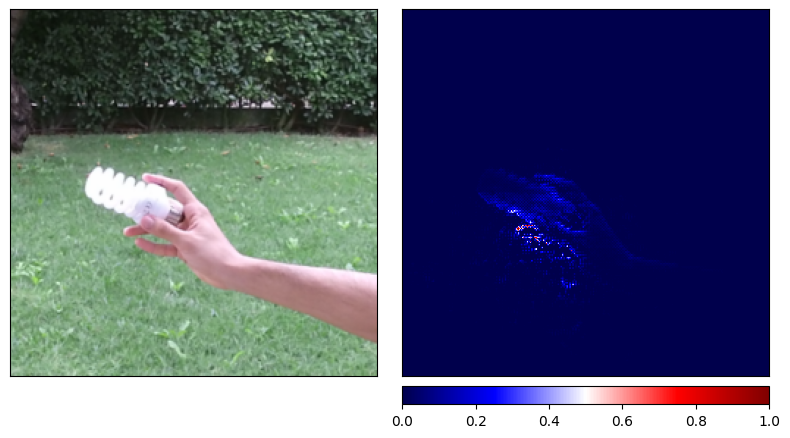

In [70]:
test_img2 = Image.open('/kaggle/input/aiunict-2023/test/103.jpg')

transformed_img2 = transform(test_img2)
input_img2 = transform_normalize(transformed_img2)
input_img2 = input_img2.unsqueeze(0).to(dev)
transformed_img2 = transformed_img2.to(dev)

output2 = model(input_img2)
output2 = F.softmax(output2, dim=1)
prediction_score2, pred_label_idx2 = torch.topk(output2, 1)
pred_label_idx2.squeeze_()

gg2 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr2 = gg2.attribute(input_img2, pred_label_idx2)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

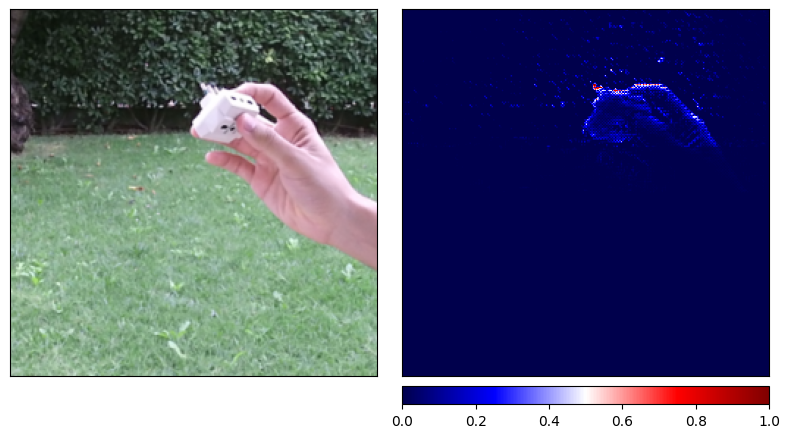

In [63]:
test_img3 = Image.open('/kaggle/input/aiunict-2023/test/038.jpg')

transformed_img3 = transform(test_img3)
input_img3 = transform_normalize(transformed_img3)
input_img3 = input_img3.unsqueeze(0).to(dev)
transformed_img3 = transformed_img3.to(dev)

output3 = model(input_img3)
output3 = F.softmax(output3, dim=1)
prediction_score3, pred_label_idx3 = torch.topk(output3, 1)
pred_label_idx3.squeeze_()

gg3 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr3 = gg3.attribute(input_img3, pred_label_idx3)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr3.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img3.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

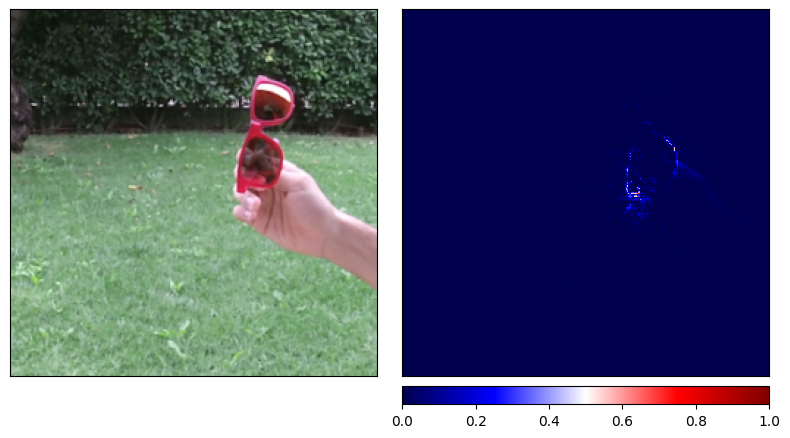

In [56]:
test_img4 = Image.open('/kaggle/input/aiunict-2023/test/005.jpg')

transformed_img4 = transform(test_img4)
input_img4 = transform_normalize(transformed_img4)
input_img4 = input_img4.unsqueeze(0).to(dev)
transformed_img4 = transformed_img4.to(dev)

output4 = model(input_img4)
output4 = F.softmax(output4, dim=1)
prediction_score4, pred_label_idx4 = torch.topk(output4, 1)
pred_label_idx4.squeeze_()

gg4 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr4 = gg4.attribute(input_img4, pred_label_idx4)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr4.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img4.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

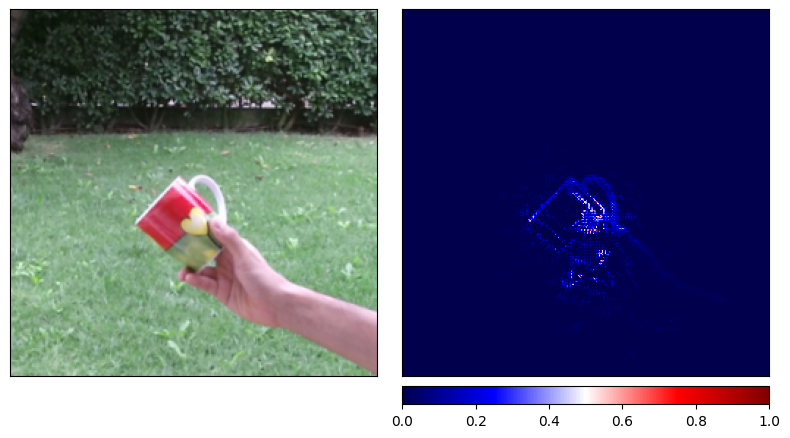

In [57]:
test_img5 = Image.open('/kaggle/input/aiunict-2023/test/007.jpg')

transformed_img5 = transform(test_img5)
input_img5 = transform_normalize(transformed_img5)
input_img5 = input_img5.unsqueeze(0).to(dev)
transformed_img5 = transformed_img5.to(dev)

output5 = model(input_img5)
output5 = F.softmax(output5, dim=1)
prediction_score5, pred_label_idx5 = torch.topk(output5, 1)
pred_label_idx5.squeeze_()

gg5 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr5 = gg5.attribute(input_img5, pred_label_idx5)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr5.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img5.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

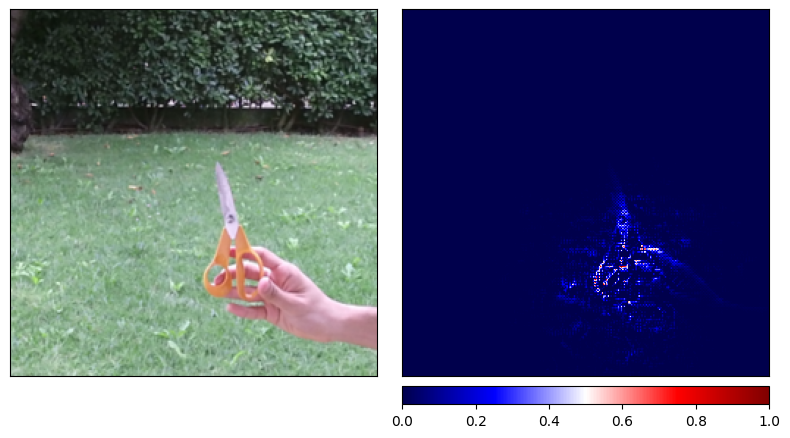

In [60]:
test_img6 = Image.open('/kaggle/input/aiunict-2023/test/016.jpg')

transformed_img6 = transform(test_img6)
input_img6 = transform_normalize(transformed_img6)
input_img6 = input_img6.unsqueeze(0).to(dev)
transformed_img6 = transformed_img6.to(dev)

output6 = model(input_img6)
output6 = F.softmax(output6, dim=1)
prediction_score6, pred_label_idx6 = torch.topk(output6, 1)
pred_label_idx6.squeeze_()

gg6 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr6 = gg6.attribute(input_img6, pred_label_idx6)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr6.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img6.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

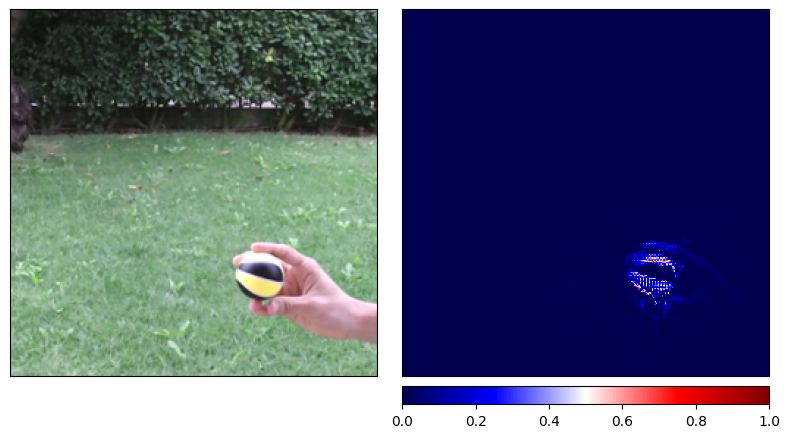

In [71]:
test_img7 = Image.open('/kaggle/input/aiunict-2023/test/111.jpg')

transformed_img7 = transform(test_img7)
input_img7 = transform_normalize(transformed_img7)
input_img7 = input_img7.unsqueeze(0).to(dev)
transformed_img7 = transformed_img7.to(dev)

output7 = model(input_img7)
output7 = F.softmax(output7, dim=1)
prediction_score7, pred_label_idx7 = torch.topk(output7, 1)
pred_label_idx7.squeeze_()

gg7 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr7 = gg7.attribute(input_img7, pred_label_idx7)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr7.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img7.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

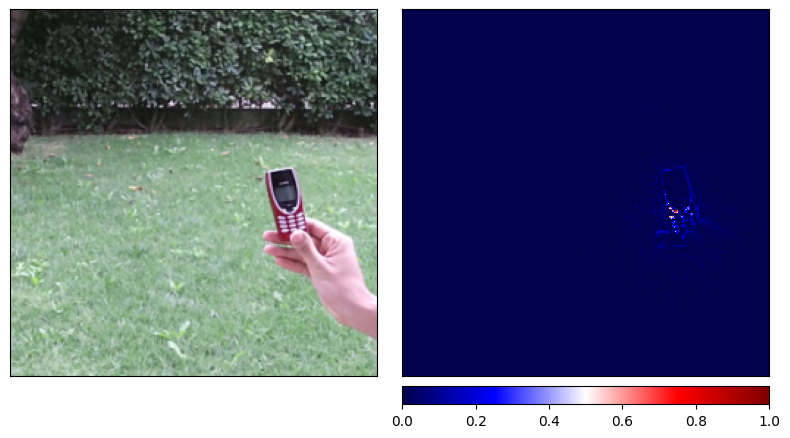

In [72]:
test_img8 = Image.open('/kaggle/input/aiunict-2023/test/020.jpg')

transformed_img8 = transform(test_img8)
input_img8 = transform_normalize(transformed_img8)
input_img8 = input_img8.unsqueeze(0).to(dev)
transformed_img8 = transformed_img8.to(dev)

output8 = model(input_img8)
output8 = F.softmax(output8, dim=1)
prediction_score8, pred_label_idx8 = torch.topk(output8, 1)
pred_label_idx8.squeeze_()

gg8 = GuidedGradCam(model, model.block_3x3_exit_2)
gg_attr8 = gg8.attribute(input_img8, pred_label_idx8)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr8.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img8.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

## Testing

Finally, the images coming from the test folder has been loaded and transformed in the same way as the validation set: 

* center cropped at 300 pixels,
* resized at 250 pixels, 
* normalized.

Then, a dataloader with a batch of 64, not shuffled and not discarding the final batch was created and the model was feeded with the test set images to generate predictions. \
The generated submission gives me an accuracy of 71.25%, compared with a pretrained model on the same preprocessed images which produced an accuracy of 80%. 

In [37]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform = None):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
        

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_image = self.transform(image)
        return tensor_image
    
testdataset = CustomDataSet(main_dir = '/kaggle/input/aiunict-2023/test', transform = notransform)  
test_loader = DataLoader(testdataset , batch_size=64, shuffle=False, drop_last=False)

In [38]:
predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(dev)
        outputs = model(images)
        predicted = F.softmax(outputs,1)
        pred_class_idx = torch.argmax(predicted, dim=1)
        pred_class_idx = pred_class_idx.cpu()
        predictions.extend(pred_class_idx.numpy())

In [41]:
bb = pd.read_csv('/kaggle/input/aiunict-2023/test.csv')
submission = pd.DataFrame({'image' : bb.iloc[:,0], 'class': predictions})
submission.to_csv('submission.csv', index = False)